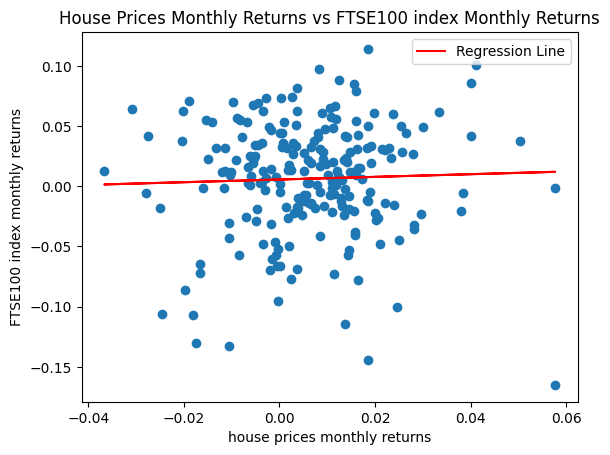

Correlation Coefficient: 0.034976120776073316
p-value: 0.6050395332131359


In [28]:
# Q1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm

def question_one():
    house_price_worksheet = pd.read_excel("Monthly.xls")
    ftse_worksheet = pd.read_csv('FTSE100.csv')
    
    # retrieve all dates and average house prices of those dates
    dates = np.array(house_price_worksheet.iloc[:, 0], dtype='datetime64[D]')
    
    # find where December 2016 is located and only retrieve data up to that date
    i = np.where(dates == np.array(['2016-12-01'], dtype='datetime64[D]'))[0][0]
    dates_house = dates[:i+1]
    avg_house_price = house_price_worksheet["Average House Price"].iloc[:i+1]
    
    # create dataframe with dates and average house prices
    data = {
        "Date" : dates_house,
        "Average House Price" : avg_house_price
    }
    df_avg_house_price = pd.DataFrame(data)
    
    # retrieve FTSE data by date
    dates_ftse = np.array(pd.to_datetime(ftse_worksheet['Date']), dtype='datetime64[D]')
    adj_close = np.array(ftse_worksheet['Adj Close'])
    dates_ftse = np.flip(dates_ftse)
    adj_close = np.flip(adj_close)
    
    # create dataframe with dates and adj close values
    data = {
        "Date" : dates_ftse,
        "Adj Close" : adj_close
    }
    df_ftse = pd.DataFrame(data)
    
    # merge both dataframes to have average house price and FTSE index in one data structure
    df = pd.merge(df_avg_house_price, df_ftse, on='Date')
   
    # calculate monthly returns 
    monthly_return_house = df["Average House Price"].pct_change().dropna()
    monthly_return_ftse = df["Adj Close"].pct_change().dropna()

    X = sm.add_constant(monthly_return_house)
    model = sm.OLS(monthly_return_ftse, X).fit()

    plt.scatter(monthly_return_house, monthly_return_ftse)
    plt.plot(monthly_return_house, model.fittedvalues, color='red', label='Regression Line')
    plt.xlabel("house prices monthly returns")
    plt.ylabel("FTSE100 index monthly returns")
    plt.legend()
    plt.title("House Prices Monthly Returns vs FTSE100 index Monthly Returns")
    plt.show()
    
    res = scipy.stats.linregress(monthly_return_house, monthly_return_ftse)

    print("Correlation Coefficient:", res.rvalue)

    # The results tell us that there is very little correlation between the house prices montly returns and the FTSE100 index
    # monthly returns. This is shown in the correlation coefficient that has a value very close to 0 and in the graph where
    # the predicted line has a very small slope. 

    # Null hypothesis is that there's no relationship between the house prices monthly returns and the FTSE100 index monthly returns. 
    # Alternative hypothesis is that there does exist a significant relationship between the house prices monthly returns and the FTSE100 index monthly returns.
    print("p-value:", res.pvalue)
    # p-value is greater than alpha, hence the null hypothesis is accepted.

question_one()

In [29]:
# Q2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm

from tabulate import tabulate
from sklearn.linear_model import LassoLarsIC
from stepwise_regression import step_reg

def question_two():
    # read the csv file
    college_worksheet = pd.read_csv('College.csv')

    # retrieve the necessary columns (predictor variables)
    num_applications = college_worksheet['Apps']
    num_enrolled = college_worksheet['Enroll']
    num_out_state = college_worksheet['Outstate']
    num_top10 = college_worksheet['Top10perc']
    num_top25 = college_worksheet['Top25perc']

    # retrieve the target variable
    grad_rate = college_worksheet['Grad.Rate']
    
    # calculate the correlation coefficients of variables extracted. 
    # coeffcients matrix will contain coefficients of every variable against each other.
    # i.e. coefficient (i, j) in matrix will be from variables dataset[i] and dataset[j]
    # last column will be the correlation coefficients of all the predictor variable against target
    dataset = [num_applications, num_enrolled, num_out_state, num_top10, num_top25]
    coefficents = np.zeros((5, 5))
    for i in range(len(dataset)):
        x = dataset[i]
        for j in range(len(dataset)):
            y = dataset[j]
            coeff = scipy.stats.pearsonr(x, y)[0]
            coefficents[i, j] = coeff
    target_coeffs = np.zeros(5)
    for i in range(len(dataset)):
        x = dataset[i]
        coeff = scipy.stats.pearsonr(x, grad_rate)[0]
        target_coeffs[i] = coeff
    coefficents = np.hstack((coefficents, target_coeffs.reshape(-1, 1)))
    headers = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc', 'Grad.rate']
    coeff_table = tabulate(coefficents, headers=headers, tablefmt="grid")
    print(coeff_table)

    # use stepwise to build linear regression model with graduation rate as the dependent variable
    X = college_worksheet[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']]
    y = college_worksheet['Grad.Rate']
    vars = step_reg.forward_regression(X, y, 0.05, verbose=False)
    print('useful predictors with stepwise:', vars)

    # predictor variables useful in predicting the graduation rate are the number of out of state
    # students and the number of admitted students who were in the top 25% of their class.

    # use BIC to build linear regression model with graduation rate as the dependent variable
    model = LassoLarsIC('bic').fit(X, y)
    i = np.where(model.coef_ != 0)[0]
    print("useful predictors with BIC:", np.array(headers[:-1])[i])

    # compute accuracy of model using only useful predictors (BIC vs stepwise)
    X_step_wise = college_worksheet[vars]
    X_step_wise = sm.add_constant(X_step_wise)
    model_step_wise = sm.OLS(y, X_step_wise).fit()
    print("adj R-squared for model with only useful predictors chosen by stepwise:", model_step_wise.rsquared_adj)

    X_bic = college_worksheet[list(np.array(headers[:-1])[i])]
    X_bic = sm.add_constant(X_bic)
    model_bic = sm.OLS(y, X_bic).fit()
    print("adj R-squared for model with only useful predictors chosen by BIC:", model_bic.rsquared_adj)

    # compute accuracy of model using only all predictors
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("adj R-squared for model with all predictors:", model.rsquared_adj)
    
    # prediction of CMU grad rate with most accurate model (predictor variables chosen by BIC)
    colleges = college_worksheet.iloc[:, 0]
    i = np.where(colleges == 'Carnegie Mellon University')[0][0]
    CMU_pred_grad = model_bic.fittedvalues[i]
    print("Predicted graduation rate for CMU:", CMU_pred_grad)

    
question_two()

+----------+-----------+------------+-------------+-------------+-------------+
|     Apps |    Enroll |   Outstate |   Top10perc |   Top25perc |   Grad.rate |
+==========+===========+============+=============+=============+=============+
| 1        |  0.846822 |   0.050159 |    0.338834 |    0.35164  |    0.146755 |
+----------+-----------+------------+-------------+-------------+-------------+
| 0.846822 |  1        |  -0.155477 |    0.181294 |    0.226745 |   -0.022341 |
+----------+-----------+------------+-------------+-------------+-------------+
| 0.050159 | -0.155477 |   1        |    0.562331 |    0.489394 |    0.57129  |
+----------+-----------+------------+-------------+-------------+-------------+
| 0.338834 |  0.181294 |   0.562331 |    1        |    0.891995 |    0.494989 |
+----------+-----------+------------+-------------+-------------+-------------+
| 0.35164  |  0.226745 |   0.489394 |    0.891995 |    1        |    0.477281 |
+----------+-----------+------------+---

/Users/beforeyasser/Documents/18-785/ycorzo_DIAML_Assignment3/.conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


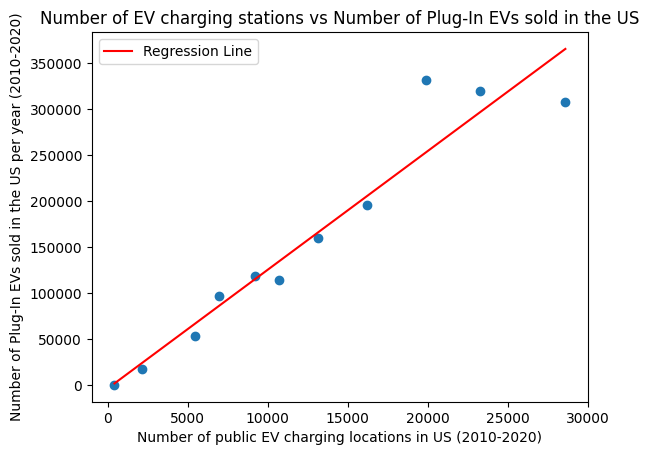

p-value: 2.4693241564609166e-06
predicted electric vehicle sales: 594634.3461290485


In [30]:
# Q3
import numpy as np
import pandas as pd
import statsmodels.api as sm

def question_three():
    # Assumptions: There is a significant directly proportional relationship between number of public ev charging stations and 
    # sales of electric vehicles.

    # read excel sheets
    ev_charging_stations_worksheet = pd.read_excel('EV_charging_stations.xlsx')
    ev_sales_worksheet = pd.read_excel('EV_sales.xlsx', sheet_name='1-19')

    # extract necessary rows/columns for years 2010-2020
    plug_in = ev_sales_worksheet.iloc[2, 11:22]
    ev = ev_sales_worksheet.iloc[3, 11:22].replace('Z', 0)
    ev_sales = plug_in + ev
    ev_sales = ev_sales.to_numpy().astype('int')
    num_stations = ev_charging_stations_worksheet.iloc[5:16, 3].to_numpy().reshape((-1, 1))
    num_stations = sm.add_constant(num_stations)
    num_stations = num_stations.astype('int')

    # create linear regression model
    model = sm.OLS(ev_sales, num_stations).fit()
    num_stations = num_stations[:, 1].T
    plt.scatter(num_stations, ev_sales)
    plt.plot(num_stations, model.fittedvalues, color='red', label="Regression Line")
    plt.xlabel("Number of public EV charging locations in US (2010-2020)")
    plt.ylabel("Number of Plug-In EVs sold in the US per year (2010-2020)")
    plt.title("Number of EV charging stations vs Number of Plug-In EVs sold in the US")
    plt.legend()
    plt.show()

    # Null hypothesis: There is no relationship between number of public ev charging stations and sales of electric vehicles.
    # Alternate hypothesis: There is significant directly proportional relationship between number of public ev charging stations and 
    # sales of electric vehicles.
    
    # retrieve p-value
    print("p-value:", model.pvalues[-1])

    # Since p-value is less than alpha, null hypothesis is rejected.

    # predict EV sales in 2021
    # We are using the number of chargers available in 2021 from dataset (46407 charging stations) to help model predict number of EVs sold.
    x_new = np.array([[1, 46407]])
    y_new = model.predict(x_new)
    print("predicted electric vehicle sales:", y_new[0])

question_three()

In [31]:
# Q4
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def question_four():
    # read csv file
    worksheet = pd.read_csv('ODA-ISR_LUR.csv')
    dates = worksheet['Date'].to_numpy(dtype='datetime64[D]')
    values = worksheet['Value'].to_numpy()
    i = np.where(dates == np.array(['2012-12-31'], dtype='datetime64[D]'))[0][0]

    # trim dataset
    dates = dates[i:].reshape((-1, 1))
    dates = dates.astype("long")
    values = values[i:]

    # create linear regression model
    model = LinearRegression().fit(dates, values)

    # predict unemployment rate for years 2013-2020
    dates_new = np.array(['2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31'], dtype='datetime64[D]')
    dates_new = dates_new.astype("long")
    values_pred = model.predict(dates_new.reshape((-1, 1)))
    print("rate of unemployment by 2020:", values_pred[-1])

    # calculate MAPE for performance
    values_pred = model.predict(dates)
    print("MAPE:", mean_absolute_percentage_error(values, values_pred)*100)
    
question_four()

rate of unemployment by 2020: 12.078691048979863
MAPE: 21.992602606313422
